# Sine wave. Inverse kinematics. 

In the previous practice we dealt with step signal. Let's dive into our workout routine with array of elements as a reference. For the sake of simplicity, within this script we deal with sine wave. 

As always we start with uploading needed libraries

In [1]:
from os import path
import mujoco
import mujoco_viewer
import numpy as np
from matplotlib import pyplot as plt

Let us declare constant variables such as simulation time `SIMEND`, step numbers `STEP_NUM`, name of  xml file `MODEL_NAME`, and MuJoCo entities: `model` and `data`

In [2]:
SIMEND = 10
TIMESTEP = 0.002
STEP_NUM = int(SIMEND/TIMESTEP)
MODEL_NAME = 'two_rot_robot.xml'

ROOT = path.abspath('')
FOLDER_PATH = path.join(ROOT, '')
MODEL_PATH = path.join(FOLDER_PATH, MODEL_NAME)

model = mujoco.MjModel.from_xml_path(MODEL_PATH)
data = mujoco.MjData(model)

Our first activity will involve implementing position-velocity control for the servo.

To understand the next piece of code you need to open the xml file and to take a look at `actuator` container. You'll see there a few actuators: (0) `motor`, (1) `position`, (2) velocity for the joint A, and (3) `motor`, (4) `position`, (5) `velocity` for the joint B. To implement servo control we need only position and velocity types, i.e., actuators with IDs 1 and 2 for the joint A, and with IDs 4 and 5 for the joint B. Ids 0 and 3 are needed for torque control.

In [3]:
def set_position_servo(mjmodel, actuator_no, kp):
    mjmodel.actuator_gainprm[actuator_no, 0] = kp
    mjmodel.actuator_biasprm[actuator_no, 1] = -kp


def set_velocity_servo(mjmodel, actuator_no, kv):
    mjmodel.actuator_gainprm[actuator_no, 0] = kv
    mjmodel.actuator_biasprm[actuator_no, 2] = -kv

def controller(mjmodel, mjdata, ref):

    ID_POS_A = 1
    ID_VEL_A = 2
    ID_POS_B = 4
    ID_VEL_B = 5
    ID_JOINT_A = 0
    ID_JOINT_B = 1

    set_position_servo(mjmodel, ID_POS_A, 10)
    set_velocity_servo(mjmodel, ID_VEL_A, 1)
    mjdata.ctrl[ID_POS_A] = ref[ID_JOINT_A]
    
    set_position_servo(mjmodel, ID_POS_B, 10)
    set_velocity_servo(mjmodel, ID_VEL_B, 1)
    mjdata.ctrl[ID_POS_B] = ref[ID_JOINT_B]

We have to declare a reference array for the end effector. Here we are using sine wave. 

In [4]:
FREQ = 1
AMP_1 = 0.1
AMP_2 = 0.1
BIAS_1 = - 0.12
BIAS_2 = 0.15

timeseries = np.linspace(0, SIMEND, STEP_NUM)
end_eff_ref = np.array([AMP_1 * np.sin(FREQ * timeseries) + BIAS_1,
                        AMP_2 * np.sin(FREQ * timeseries) + BIAS_2])

If we want to start the motion not from a configuration denoted as initial in URDF (or MJCF), but from a custom initial state, we can use `mj_forward` function. 

For example here we will start our motion from a custom configuration such that the end effector  initial position will match with the `end_eff_ref[0]` 

In [5]:
theta1 = 1.10
theta2 = -2.27
ID_JOINT_A = 0
ID_JOINT_B = 1
data.qpos[ID_JOINT_A] = theta1 # set position
data.qpos[ID_JOINT_B] = theta2 # set position
mujoco.mj_forward(model, data)

I'll add comments regarding the next piece of code later 

In [6]:
viewer = mujoco_viewer.MujocoViewer(model, data,
                                    title = "2R_robot",
                                    width = 1920,
                                    height = 1080)

for i in range(STEP_NUM):
    if viewer.is_alive:
        # 1. Compute Jacobian
        tip = data.site_xpos[0]
        jacp = np.zeros((3, 2))
        mujoco.mj_jac(model, data, jacp, None, tip, 2)
        jac = jacp[[0, 2], :]

        # 2. Compute inverse Jacobian
        jac_inv = np.linalg.inv(jac)

        # 3. Compute dX
        dX = np.array([end_eff_ref[0][i]-tip[0],
                       end_eff_ref[1][i]-tip[2]])

        # 4. Compute dq
        dq = jac_inv.dot(dX)

        # 5. Update theta1 and theta2
        theta1 += dq[0]
        theta2 += dq[1]

        data.qpos[0] = theta1
        data.qpos[1] = theta2

        if i == 0:
            end_eff_act = np.array([data.site_xpos[0]])
            theta_act = np.array([[theta1, theta2]])
        else:
            end_eff_act = np.concatenate((end_eff_act, [np.array(tip)]), axis=0)
            theta_act = np.concatenate((theta_act, np.array([[theta1, theta2]])), axis=0)

        ref = [theta1, theta2]

        mujoco.set_mjcb_control(controller(model, data, ref))
        mujoco.mj_step(model, data)
        viewer.render()
    else:
        break

viewer.close()

For extra practice you can make some plots to compare reference and actual motion.

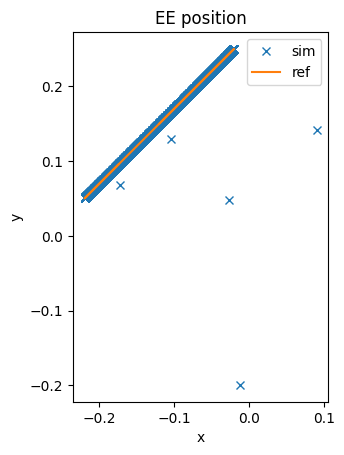

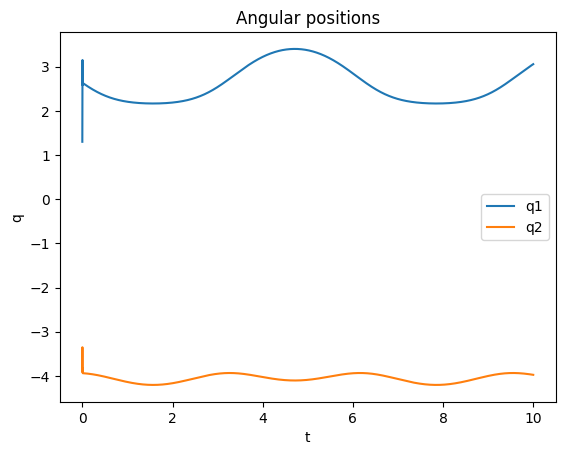

In [7]:
plt.figure(1)
plt.title("EE position")
plt.plot(end_eff_act.T[0], end_eff_act.T[2], 'x', label='sim')
plt.plot(end_eff_ref[0], end_eff_ref[1], label='ref')
plt.gca().set_aspect('equal')
plt.ylabel("y")
plt.xlabel("x")
plt.legend()
plt.show(block=False)

plt.figure(2)
plt.title("Angular positions")
plt.plot(timeseries, theta_act.T[0], label='q1')
plt.plot(timeseries, theta_act.T[1], label='q2')
plt.ylabel("q")
plt.xlabel("t")
plt.legend()
plt.show(block=False)

plt.close()